In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV,ShuffleSplit
from sklearn.metrics import confusion_matrix, roc_curve,auc
from treeinterpreter import treeinterpreter as ti
from sklearn.pipeline import Pipeline
from IPython.display import display

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format',lambda x:'%.3f' % x)
%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 5)

height has been deprecated.



In [44]:
def findNulls(df):
    print "cell with missing values: %d" % sum(df.isnull().values.ravel())
    print "rows with missing values somwhere: %d" % sum([True for idx,row in df.iterrows() if any(row.isnull())])
    
def getUniques(columns,df):
    for col in columns:
        print '%s distincts\n' % col
        print df[col].unique()
        
def getDataFrameStats(df):
    print 'Contains %d elements' % df.shape[0]
    findNulls(df)

In [12]:
df1 = pd.read_csv('./dataset/CSC_LSanalysis_21.02.18.csv',index_col=0)
df2 = pd.read_csv('./dataset/CSC_SFDC_Leads_Oct1-Feb21_All.csv',index_col=0)

/Users/alexanderpan/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (18,28,32,39,45,60,69,77,80,91,92,93,103,106,107,108,109,110,112,113,114,115,116,117,124,130,135,136,141,142,143,144,145,148,150,151,152,153,154,155,157,158,159,162,163,164,165,166,167,168,169,170,171,172,174,175,176,186,187,188,189) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [124]:
cols = ['Email Address','Country','Job Level - Scoring Only','Job Function - Scoring Only',
        'Region','Title','Job Title Class','Decision Maker Type','Job Level','State or Province',
        'Business Relation Status','Rep Company Employees','Rep Vertical Market','Rep Account Type',
        'Purchase Role','Rep Interests Networking','Persona','Rep Number Of PCs','Job Role','Department',
        'Technical Score','Engagement Score','Rep Line Of Business','Rep Company Sites Country',
        'Subject Interest 1','Rep Tech Responsibility','Industry','Rep Number Of Servers',
        'Rep Number Of Phones']

cols2 = ['Email','Lead Record Type','Lead Status','Converted'] #taking out create date
df = df1[cols].merge(df2[cols2],how='inner',left_on='Email Address',right_on='Email')
drop_cols = ['Email Address','Email']
df.drop(drop_cols,axis=1,inplace=True)

In [125]:
df_AMER = df.loc[df['Region']=='AMER']
df_CHINA = df.loc[df['Region']=='GREATER CHINA']
df_APJ = df.loc[df['Region']=='APJ']
df_EMEAR = df.loc[df['Region']=='EMEAR']


# Americas Region

In [230]:
#cols = df_AMER.columns.tolist()
cols = ['Country',
 'Job Level - Scoring Only',
 'Job Function - Scoring Only',
 'Job Title Class',
 'Decision Maker Type',
 'Job Level',
 'State or Province',
 'Lead Record Type',
 'Lead Status']
df_AMER.fillna('UNKNOWN',inplace=True)
X = df_AMER[cols]
y = df_AMER['Converted']

for column in cols: 
    df_dummies = pd.get_dummies(X[column])
    df_dummies.columns = [ str(column)+": "+str(col) for col in df_dummies.columns]
    df_new = pd.concat([X, df_dummies], axis=1)
    X = df_new 
    X = X.drop([column], axis=1)
X = X.apply(pd.to_numeric)  
y = pd.to_numeric(y)
##X.head()

In [231]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)

#Using Training data, to make validation set. 60-20-20 (training, valid, test)
cv = ShuffleSplit(n_splits=50,test_size=.25)

In [232]:
%%time
rfc_model = Pipeline([('rfc',RandomForestClassifier(n_estimators=100,
                                                    max_features='auto',
                                                    oob_score=True))])

param_grid=[{'rfc__max_depth': [4,5,6,7,8,None],
             'rfc__criterion': ['entropy']}]
gs_rfc_amer = GridSearchCV(estimator=rfc_model,
                      param_grid = param_grid,
                      scoring = 'roc_auc',
                      cv = cv,
                      n_jobs=-1)
gs_rfc_amer.fit(X_train,y_train)
print(gs_rfc_amer.best_score_)
print(gs_rfc_amer.best_params_)


0.932691780689
{'rfc__criterion': 'entropy', 'rfc__max_depth': 8}
CPU times: user 1min 21s, sys: 24 s, total: 1min 45s
Wall time: 1h 22min 3s


Test Score Accuracy: 93.27% +/- 0.37%
Train Score Accuracy: 94.40% +/- 0.23%


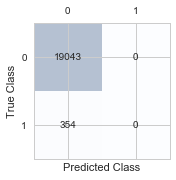

Accuracy: 0.98
Missclassification Rate: 0.02
Converted(1) Positive Rate(Recall): 0.00
Not Converted(0) Positive Rate(Sensitivity): 1.00
Specificity(proportion of predicted Not Converted(0): 0.98


In [233]:
#Using Confusion matrix to test accuracy
i = gs_rfc_amer.best_index_
test_mean = gs_rfc_amer.cv_results_['mean_test_score'][i] * 100
std_test = gs_rfc_amer.cv_results_['std_test_score'][i] * 100
train_mean = gs_rfc_amer.cv_results_['mean_train_score'][i] * 100
std_train = gs_rfc_amer.cv_results_['std_train_score'][i] * 100
print("Test Score Accuracy: %.2f%% +/- %.2f%%" % (test_mean,std_test))
print("Train Score Accuracy: %.2f%% +/- %.2f%%" % (train_mean,std_train))

y_pred = gs_rfc_amer.predict(X_test)
confmat = confusion_matrix(y_test,y_pred,labels=[0,1])
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,
                s=confmat[i,j],
                va='center',ha='center')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

total = float(X_test.shape[0])
TN = float(confmat[0][0])
TP = float(confmat[1][1])
FP = float(confmat[0][1])
FN = float(confmat[1][0])
print("Accuracy: %.2f" % ((TP+TN)/total))
print("Missclassification Rate: %.2f" % ((FN+FP)/total))
print("Converted(1) Positive Rate(Recall): %.2f" % (TP/(TP+FN)))
print("Not Converted(0) Positive Rate(Sensitivity): %.2f" % (TN/(TN+FP)))
#print("Precision(proportion of predicted Converted(1)): %.2f" % (TP/(TP+FP)))
print("Specificity(proportion of predicted Not Converted(0): %.2f" % (TN/(TN+FN)))

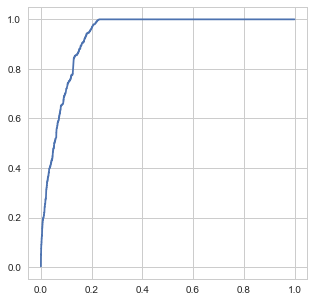

AUC(Area Under Curve) score: 0.931968


In [234]:
#ROC Curve
probas = gs_rfc_amer.predict_proba(X_test)
fpr,tpr, thresholds = roc_curve(y_test, probas[:,1])
plt.plot(fpr,tpr)
plt.show()
print'AUC(Area Under Curve) score: %f' % auc(fpr,tpr)

In [235]:
fts = gs_rfc_amer.best_estimator_.named_steps['rfc'].feature_importances_
ft_imp = zip(X.columns.tolist(),fts)
ft_df = pd.DataFrame(ft_imp,columns=['Feature','Ft_Importance'])

print 'Top 10 Feature Importances'
display(ft_df.sort_values('Ft_Importance',ascending=False).head(10))

print 'Bottom 10 Feature Importances'
display(ft_df.sort_values('Ft_Importance',ascending=False).tail(10))

Top 10 Feature Importances


,Feature,Ft_Importance
940,Lead Status: 2 Accepted-Mine/Channel,0.258
938,Lead Record Type: eLeads,0.095
939,Lead Status: 1 Waiting,0.075
936,Lead Record Type: Prospect,0.070
933,Lead Record Type: Closed,0.048
956,Lead Status: Marketing Unqualified,0.046
934,Lead Record Type: Manual,0.043
954,Lead Status: Inactive,0.034
16,Country: COSTA RICA,0.025
573,State or Province: MG,0.017


Bottom 10 Feature Importances


,Feature,Ft_Importance
416,State or Province: Cumbaya,0.000
417,State or Province: Cundinamarca,0.000
418,State or Province: Cundinamerca,0.000
419,State or Province: Cuscatlán,0.000
421,State or Province: D.C.,0.000
424,State or Province: DEPARTAMENTO,0.000
426,State or Province: DGO,0.000
428,State or Province: DISTRITO C,0.000
429,State or Province: DISTRITO CAPITAL,0.000
480,State or Province: Guanajuato,0.000


In [237]:
print 'All Feature Importances'
display(ft_df)

All Feature Importances


,Feature,Ft_Importance
0,Country: AFGHANISTAN,0.000
1,Country: ANGUILLA,0.000
2,Country: ANTIGUA AND BARBUDA,0.000
3,Country: ARGENTINA,0.000
4,Country: ARUBA,0.000
5,Country: BAHAMAS,0.000
6,Country: BARBADOS,0.000
7,Country: BELIZE,0.000
8,Country: BERMUDA,0.000
9,Country: BOLIVIA,0.000


# China

In [227]:
cols = ['Country',
 'Job Level - Scoring Only',
 'Job Function - Scoring Only',
 'Job Title Class',
 'Decision Maker Type',
 'Business Relation Status',
 'Lead Record Type',
 'Lead Status']
df_CHINA.fillna('UNKNOWN',inplace=True)
X = df_CHINA[cols]
y = df_CHINA['Converted']

for column in cols: 
    df_dummies = pd.get_dummies(X[column])
    df_dummies.columns = [ str(column)+": "+str(col) for col in df_dummies.columns]
    df_new = pd.concat([X, df_dummies], axis=1)
    X = df_new 
    X = X.drop([column], axis=1)
X = X.apply(pd.to_numeric)  
y = pd.to_numeric(y)
#X.head()

In [228]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)

#Using Training data, to make validation set. 60-20-20 (training, valid, test)
cv = ShuffleSplit(n_splits=50,test_size=.25)

In [176]:
%%time
rfc_model = Pipeline([('rfc',RandomForestClassifier(n_estimators=100,
                                                    max_features='auto',
                                                    oob_score=True))])

param_grid=[{'rfc__max_depth': [5,6,7,8,9,None],
             'rfc__criterion': ['entropy']}]
gs_rfc_china = GridSearchCV(estimator=rfc_model,
                      param_grid = param_grid,
                      scoring = 'roc_auc',
                      cv = cv,
                      n_jobs=-1)
gs_rfc_china.fit(X_train,y_train)
print(gs_rfc_china.best_score_)
print(gs_rfc_china.best_params_)

0.989398510615
{'rfc__criterion': 'entropy', 'rfc__max_depth': 9}
CPU times: user 7.99 s, sys: 1.42 s, total: 9.42 s
Wall time: 4min 49s


Test Score Accuracy: 98.94% +/- 0.11%
Train Score Accuracy: 99.08% +/- 0.03%


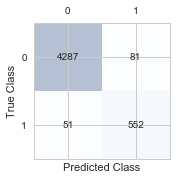

Accuracy: 0.97
Missclassification Rate: 0.03
Converted(1) Positive Rate(Recall): 0.92
Not Converted(0) Positive Rate(Sensitivity): 0.98
Precision(proportion of predicted Converted(1)): 0.87
Specificity(proportion of predicted Not Converted(0): 0.99


In [229]:
#Using Confusion matrix to test accuracy
i = gs_rfc_china.best_index_
test_mean = gs_rfc_china.cv_results_['mean_test_score'][i] * 100
std_test = gs_rfc_china.cv_results_['std_test_score'][i] * 100
train_mean = gs_rfc_china.cv_results_['mean_train_score'][i] * 100
std_train = gs_rfc_china.cv_results_['std_train_score'][i] * 100
print("Test Score Accuracy: %.2f%% +/- %.2f%%" % (test_mean,std_test))
print("Train Score Accuracy: %.2f%% +/- %.2f%%" % (train_mean,std_train))

y_pred = gs_rfc_china.predict(X_test)
confmat = confusion_matrix(y_test,y_pred,labels=[0,1])
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,
                s=confmat[i,j],
                va='center',ha='center')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

total = float(X_test.shape[0])
TN = float(confmat[0][0])
TP = float(confmat[1][1])
FP = float(confmat[0][1])
FN = float(confmat[1][0])
print("Accuracy: %.2f" % ((TP+TN)/total))
print("Missclassification Rate: %.2f" % ((FN+FP)/total))
print("Converted(1) Positive Rate(Recall): %.2f" % (TP/(TP+FN)))
print("Not Converted(0) Positive Rate(Sensitivity): %.2f" % (TN/(TN+FP)))
print("Precision(proportion of predicted Converted(1)): %.2f" % (TP/(TP+FP)))
print("Specificity(proportion of predicted Not Converted(0): %.2f" % (TN/(TN+FN)))

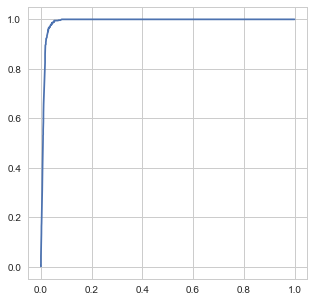

AUC(Area Under Curve) score: 0.989690


In [178]:
#ROC Curve
probas = gs_rfc_china.predict_proba(X_test)
fpr,tpr, thresholds = roc_curve(y_test, probas[:,1])
plt.plot(fpr,tpr)
plt.show()
print'AUC(Area Under Curve) score: %f' % auc(fpr,tpr)

In [205]:
fts = gs_rfc_china.best_estimator_.named_steps['rfc'].feature_importances_
ft_imp = zip(X.columns.tolist(),fts)
#ft_imp = sorted(ft_imp,key=lambda x:x[1],reverse=True)
ft_df = pd.DataFrame(ft_imp,columns=['Feature','Ft_Importance'])

print 'Top 10 Feature Importances'
display(ft_df.sort_values('Ft_Importance',ascending=False).head(10))

print 'Bottom 10 Feature Importances'
display(ft_df.sort_values('Ft_Importance',ascending=False).tail(10))


Top 10 Feature Importances


,Feature,Ft_Importance
137,Job Title Class: Business Development,0.353
134,Job Function - Scoring Only: WEALTH,0.189
135,Job Function - Scoring Only: WIRELESS,0.177
136,Job Function - Scoring Only: WPR,0.048
151,Job Title Class: MIS/IT - Data Center,0.045
150,Job Title Class: MIS/IT - Applications Dev,0.034
152,Job Title Class: MIS/IT - Operations,0.029
132,Job Function - Scoring Only: VIDEO,0.026
131,Job Function - Scoring Only: UNKNOWN,0.015
100,Job Function - Scoring Only: INFRASTRUCTURE,0.010


Bottom 10 Feature Importances


,Feature,Ft_Importance
58,Job Level - Scoring Only: INDIVIDUAL CONTRIBUTOR,0.000
60,Job Level - Scoring Only: LIEUTENANT,0.000
61,Job Level - Scoring Only: MAJOR,0.000
62,Job Level - Scoring Only: MANAGER,0.000
64,Job Level - Scoring Only: PRESIDENT,0.000
67,Job Level - Scoring Only: VICE PRESIDENT,0.000
1,Country: ANTARCTICA,0.000
97,Job Function - Scoring Only: HEALTHCARE BUSINESS,0.000
98,Job Function - Scoring Only: HOTEL,0.000
77,Job Function - Scoring Only: BUSINESS DEVELOPMENT,0.000


In [201]:
print 'Full Feature Importance'
display(ft_df.sort_values('Ft_Importance',ascending=False))

Full Feature Importance


,Feature,Ft_Importance
137,Job Title Class: Business Development,0.353
134,Job Function - Scoring Only: WEALTH,0.189
135,Job Function - Scoring Only: WIRELESS,0.177
136,Job Function - Scoring Only: WPR,0.048
151,Job Title Class: MIS/IT - Data Center,0.045
150,Job Title Class: MIS/IT - Applications Dev,0.034
152,Job Title Class: MIS/IT - Operations,0.029
132,Job Function - Scoring Only: VIDEO,0.026
131,Job Function - Scoring Only: UNKNOWN,0.015
100,Job Function - Scoring Only: INFRASTRUCTURE,0.010


# APJ

In [224]:
cols = ['Country',
 'Job Level - Scoring Only',
 'Job Function - Scoring Only',
 'Job Title Class',
 'Decision Maker Type',
 'Lead Record Type',
 'Lead Status']
df_APJ.fillna('UNKNOWN',inplace=True)
X = df_APJ[cols]
y = df_APJ['Converted']

for column in cols: 
    df_dummies = pd.get_dummies(X[column])
    df_dummies.columns = [ str(column)+": "+str(col) for col in df_dummies.columns]
    df_new = pd.concat([X, df_dummies], axis=1)
    X = df_new 
    X = X.drop([column], axis=1)
X = X.apply(pd.to_numeric)  
y = pd.to_numeric(y)
#X.head()

In [225]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)

#Using Training data, to make validation set. 60-20-20 (training, valid, test)
cv = ShuffleSplit(n_splits=50,test_size=.25)

In [207]:
%%time
rfc_model = Pipeline([('rfc',RandomForestClassifier(n_estimators=100,
                                                    max_features='auto',
                                                    oob_score=True))])

param_grid=[{'rfc__max_depth': [1,2,3,4,5,6,7,8,None],
             'rfc__criterion': ['entropy']}]
gs_rfc_apj = GridSearchCV(estimator=rfc_model,
                      param_grid = param_grid,
                      scoring = 'roc_auc',
                      cv = cv,
                      n_jobs=-1)
gs_rfc_apj.fit(X_train,y_train)
print(gs_rfc_apj.best_score_)
print(gs_rfc_apj.best_params_)

0.997203436619
{'rfc__criterion': 'entropy', 'rfc__max_depth': 8}
CPU times: user 17.7 s, sys: 2.81 s, total: 20.5 s
Wall time: 10min 37s


Test Score Accuracy: 99.72% +/- 0.03%
Train Score Accuracy: 99.78% +/- 0.02%


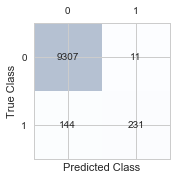

Accuracy: 0.98
Missclassification Rate: 0.02
Converted(1) Positive Rate(Recall): 0.62
Not Converted(0) Positive Rate(Sensitivity): 1.00
Precision(proportion of predicted Converted(1)): 0.95
Specificity(proportion of predicted Not Converted(0): 0.98


In [226]:
#Using Confusion matrix to test accuracy
i = gs_rfc_apj.best_index_
test_mean = gs_rfc_apj.cv_results_['mean_test_score'][i] * 100
std_test = gs_rfc_apj.cv_results_['std_test_score'][i] * 100
train_mean = gs_rfc_apj.cv_results_['mean_train_score'][i] * 100
std_train = gs_rfc_apj.cv_results_['std_train_score'][i] * 100
print("Test Score Accuracy: %.2f%% +/- %.2f%%" % (test_mean,std_test))
print("Train Score Accuracy: %.2f%% +/- %.2f%%" % (train_mean,std_train))

y_pred = gs_rfc_apj.predict(X_test)
confmat = confusion_matrix(y_test,y_pred)
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,
                s=confmat[i,j],
                va='center',ha='center')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

total = float(X_test.shape[0])
TN = float(confmat[0][0])
TP = float(confmat[1][1])
FP = float(confmat[0][1])
FN = float(confmat[1][0])
print("Accuracy: %.2f" % ((TP+TN)/total))
print("Missclassification Rate: %.2f" % ((FN+FP)/total))
print("Converted(1) Positive Rate(Recall): %.2f" % (TP/(TP+FN)))
print("Not Converted(0) Positive Rate(Sensitivity): %.2f" % (TN/(TN+FP)))
print("Precision(proportion of predicted Converted(1)): %.2f" % (TP/(TP+FP)))
print("Specificity(proportion of predicted Not Converted(0): %.2f" % (TN/(TN+FN)))

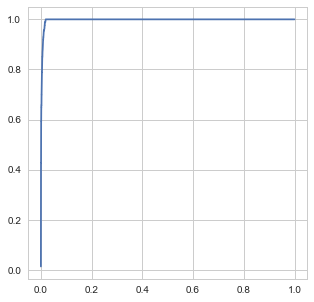

AUC(Area Under Curve) score: 0.997424


In [209]:
#ROC Curve
probas = gs_rfc_apj.predict_proba(X_test)
fpr,tpr, thresholds = roc_curve(y_test, probas[:,1])
plt.plot(fpr,tpr)
plt.show()
print'AUC(Area Under Curve) score: %f' % auc(fpr,tpr)

In [210]:
fts = gs_rfc_apj.best_estimator_.named_steps['rfc'].feature_importances_
ft_imp = zip(X.columns.tolist(),fts)
ft_df = pd.DataFrame(ft_imp,columns=['Feature','Ft_Importance'])

print 'Top 10 Feature Importances'
display(ft_df.sort_values('Ft_Importance',ascending=False).head(10))

print 'Bottom 10 Feature Importances'
display(ft_df.sort_values('Ft_Importance',ascending=False).tail(10))

Top 10 Feature Importances


,Feature,Ft_Importance
180,Lead Status: 2 Accepted-Mine/Channel,0.362
176,Lead Record Type: Prospect,0.201
178,Lead Record Type: eLeads,0.138
174,Lead Record Type: Manual,0.057
197,Lead Status: New Prospect,0.042
196,Lead Status: Marketing Unqualified,0.038
194,Lead Status: Inactive,0.024
179,Lead Status: 1 Waiting,0.021
16,"Country: KOREA, REPUBLIC OF",0.014
12,Country: INDIA,0.014


Bottom 10 Feature Importances


,Feature,Ft_Importance
1,Country: ANTARCTICA,0.000
96,Job Function - Scoring Only: GOVERNANCE,0.000
90,Job Function - Scoring Only: E-COMMERCE,0.000
88,Job Function - Scoring Only: DISTRIBUTION,0.000
85,Job Function - Scoring Only: DATA COMMUNICATIONS,0.000
80,Job Function - Scoring Only: COMPLIANCE,0.000
78,Job Function - Scoring Only: BUSINESS INTELLIG...,0.000
75,Job Function - Scoring Only: BUSINESS ANALYST,0.000
70,Job Function - Scoring Only: ANALYSIS AND REPO...,0.000
0,Country: AMERICAN SAMOA,0.000


In [211]:
print 'Full Feature Importance'
display(ft_df.sort_values('Ft_Importance',ascending=False))

Full Feature Importance


,Feature,Ft_Importance
180,Lead Status: 2 Accepted-Mine/Channel,0.362
176,Lead Record Type: Prospect,0.201
178,Lead Record Type: eLeads,0.138
174,Lead Record Type: Manual,0.057
197,Lead Status: New Prospect,0.042
196,Lead Status: Marketing Unqualified,0.038
194,Lead Status: Inactive,0.024
179,Lead Status: 1 Waiting,0.021
16,"Country: KOREA, REPUBLIC OF",0.014
12,Country: INDIA,0.014


# EMEAR

In [213]:
cols = ['Country',
 'Job Level - Scoring Only',
 'Job Function - Scoring Only',
 'Job Title Class',
 'Decision Maker Type',
 'Job Level',
 'Lead Record Type',
 'Lead Status']
df_EMEAR.fillna('UNKNOWN',inplace=True)
X = df_EMEAR[cols]
y = df_EMEAR['Converted']

for column in cols: 
    df_dummies = pd.get_dummies(X[column])
    df_dummies.columns = [ str(column)+": "+str(col) for col in df_dummies.columns]
    df_new = pd.concat([X, df_dummies], axis=1)
    X = df_new 
    X = X.drop([column], axis=1)
X = X.apply(pd.to_numeric)  
y = pd.to_numeric(y)
#X.head()

In [214]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)

#Using Training data, to make validation set. 60-20-20 (training, valid, test)
cv = ShuffleSplit(n_splits=50,test_size=.25)

In [215]:
%%time
rfc_model = Pipeline([('rfc',RandomForestClassifier(n_estimators=100,
                                                    max_features='auto',
                                                    oob_score=True))])

param_grid=[{'rfc__max_depth': [1,2,3,4,5,6,7,8,None],
             'rfc__criterion': ['entropy']}]
gs_rfc_emear = GridSearchCV(estimator=rfc_model,
                      param_grid = param_grid,
                      scoring = 'roc_auc',
                      cv = cv,
                      n_jobs=-1)
gs_rfc_emear.fit(X_train,y_train)
print(gs_rfc_emear.best_score_)
print(gs_rfc_emear.best_params_)

0.973086452176
{'rfc__criterion': 'entropy', 'rfc__max_depth': 8}
CPU times: user 20.6 s, sys: 3.89 s, total: 24.5 s
Wall time: 13min 22s


Test Score Accuracy: 97.31% +/- 0.19%
Train Score Accuracy: 98.11% +/- 0.13%


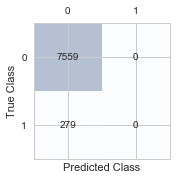

Accuracy: 0.96
Missclassification Rate: 0.04
Converted(1) Positive Rate(Recall): 0.00
Not Converted(0) Positive Rate(Sensitivity): 1.00
Specificity(proportion of predicted Not Converted(0): 0.96


In [219]:
#Using Confusion matrix to test accuracy
i = gs_rfc_emear.best_index_
test_mean = gs_rfc_emear.cv_results_['mean_test_score'][i] * 100
std_test = gs_rfc_emear.cv_results_['std_test_score'][i] * 100
train_mean = gs_rfc_emear.cv_results_['mean_train_score'][i] * 100
std_train = gs_rfc_emear.cv_results_['std_train_score'][i] * 100
print("Test Score Accuracy: %.2f%% +/- %.2f%%" % (test_mean,std_test))
print("Train Score Accuracy: %.2f%% +/- %.2f%%" % (train_mean,std_train))

y_pred = gs_rfc_emear.predict(X_test)
confmat = confusion_matrix(y_test,y_pred)
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,
                s=confmat[i,j],
                va='center',ha='center')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

total = float(X_test.shape[0])
TN = float(confmat[0][0])
TP = float(confmat[1][1])
FP = float(confmat[0][1])
FN = float(confmat[1][0])
print("Accuracy: %.2f" % ((TP+TN)/total))
print("Missclassification Rate: %.2f" % ((FN+FP)/total))
print("Converted(1) Positive Rate(Recall): %.2f" % (TP/(TP+FN)))
print("Not Converted(0) Positive Rate(Sensitivity): %.2f" % (TN/(TN+FP)))
#print("Precision(proportion of predicted Converted(1)): %.2f" % (TP/(TP+FP)))
print("Specificity(proportion of predicted Not Converted(0): %.2f" % (TN/(TN+FN)))

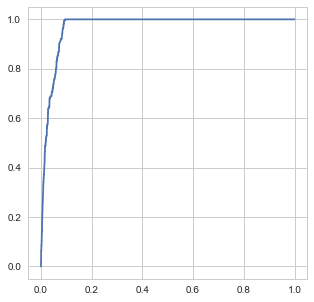

AUC(Area Under Curve) score: 0.970218


In [220]:
#ROC Curve
probas = gs_rfc_emear.predict_proba(X_test)
fpr,tpr, thresholds = roc_curve(y_test, probas[:,1])
plt.plot(fpr,tpr)
plt.show()
print'AUC(Area Under Curve) score: %f' % auc(fpr,tpr)

In [221]:
fts = gs_rfc_emear.best_estimator_.named_steps['rfc'].feature_importances_
ft_imp = zip(X.columns.tolist(),fts)
ft_df = pd.DataFrame(ft_imp,columns=['Feature','Ft_Importance'])

print 'Top 10 Feature Importances'
display(ft_df.sort_values('Ft_Importance',ascending=False).head(10))

print 'Bottom 10 Feature Importances'
display(ft_df.sort_values('Ft_Importance',ascending=False).tail(10))

Top 10 Feature Importances


,Feature,Ft_Importance
297,Lead Status: 2 Accepted-Mine/Channel,0.275
293,Lead Record Type: Prospect,0.189
295,Lead Record Type: eLeads,0.166
313,Lead Status: New Prospect,0.049
312,Lead Status: Marketing Unqualified,0.044
310,Lead Status: Inactive,0.041
296,Lead Status: 1 Waiting,0.040
292,Lead Record Type: Partner Generated Lead,0.030
291,Lead Record Type: Manual,0.023
290,Lead Record Type: Closed,0.012


Bottom 10 Feature Importances


,Feature,Ft_Importance
119,Country: SUDAN,0.000
242,Job Function - Scoring Only: UNDERWRITING,0.000
241,Job Function - Scoring Only: TRANSPORTATION,0.000
240,Job Function - Scoring Only: TRAINING AND EDUC...,0.000
123,Country: SYRIAN ARAB REPUBLIC,0.000
124,Country: Spain,0.000
237,Job Function - Scoring Only: SWITCHING,0.000
236,Job Function - Scoring Only: SUSTAINABILITY,0.000
235,Job Function - Scoring Only: SUPPLY CHAIN,0.000
316,Lead Status: Send to Sales,0.000


In [222]:
print 'Full Feature Importance'
display(ft_df.sort_values('Ft_Importance',ascending=False))

Full Feature Importance


,Feature,Ft_Importance
297,Lead Status: 2 Accepted-Mine/Channel,0.275
293,Lead Record Type: Prospect,0.189
295,Lead Record Type: eLeads,0.166
313,Lead Status: New Prospect,0.049
312,Lead Status: Marketing Unqualified,0.044
310,Lead Status: Inactive,0.041
296,Lead Status: 1 Waiting,0.040
292,Lead Record Type: Partner Generated Lead,0.030
291,Lead Record Type: Manual,0.023
290,Lead Record Type: Closed,0.012
